In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [3]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [4]:
# Save the input and target variables
print(diabetes_dataset.keys())
data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [5]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0)) / targets.std()


In [6]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)


(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [7]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation="relu", input_shape = (train_data.shape[1],)),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1),
    ])
    return model

model = get_model()


In [8]:
# Print the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [9]:
# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


In [10]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=30, validation_split=0.15, batch_size=32, verbose=False)


In [11]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.6695 - mae: 0.6586


[0.6060816950268215, 0.6585987]

#### Plot the learning curves

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

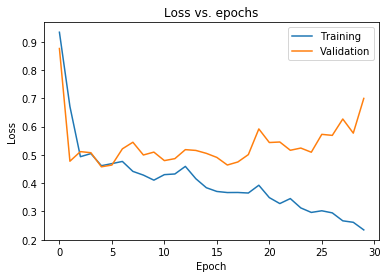

In [13]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [14]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [15]:
tf.__version__

'2.0.0'

In [16]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128,activation="relu", input_shape=(train_data.shape[1],) , kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [17]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5,0.3)


In [18]:
# Compile the model
model.compile(optimizer="adam",loss="mse",metrics=["mae"])


In [19]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)


In [20]:
# Evaluate the model on the test set
model.evaluate(test_data,test_targets, verbose=2)


45/1 - 0s - loss: 0.5851 - mae: 0.6424


[0.5905430118242899, 0.642401]

#### Plot the learning curves

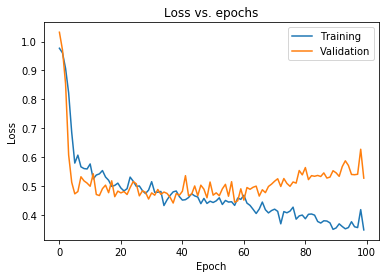

In [21]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [22]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self,logs=None):
        print("Starting training...")
    
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
    
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting bacth {batch}")
    
    def on_train_batch_end(self,batch,logs=None):
        print(f"Training: Finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self, logs=None):
        print("Training finished")


In [23]:
class TestingCallback(Callback):
    
    def on_test_begin(self,logs=None):
        print("Starting testing...")
    
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting bacth {batch}")
    
    def on_test_batch_end(self,batch,logs=None):
        print(f"Testing: Finished batch {batch}")
        
    def on_test_end(self, logs=None):
        print("Testing finished")

In [24]:
class PredictionCallback(Callback):
    
    def on_predict_begin(self,logs=None):
        print("Starting Predicting...")
    
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Predicting: Starting bacth {batch}")
    
    def on_predict_batch_end(self,batch,logs=None):
        print(f"Predicting: Finished batch {batch}")
        
    def on_predict_end(self, logs=None):
        print("Predicting finished")

In [25]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)


In [26]:
# Compile the model
model.compile(optimizer="adam",loss="mse")


#### Train the model with the callback

In [27]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False,callbacks=[TrainingCallback()])


Starting training...
Starting epoch 0
Training: Starting bacth 0
Training: Finished batch 0
Training: Starting bacth 1
Training: Finished batch 1
Training: Starting bacth 2
Training: Finished batch 2
Training: Starting bacth 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting bacth 0
Training: Finished batch 0
Training: Starting bacth 1
Training: Finished batch 1
Training: Starting bacth 2
Training: Finished batch 2
Training: Starting bacth 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting bacth 0
Training: Finished batch 0
Training: Starting bacth 1
Training: Finished batch 1
Training: Starting bacth 2
Training: Finished batch 2
Training: Starting bacth 3
Training: Finished batch 3
Finished epoch 2
Training finished


In [28]:
# Evaluate the model

model.evaluate(test_data,test_targets, verbose=False, callbacks=[TestingCallback()])

Starting testing...
Testing: Starting bacth 0
Testing: Finished batch 0
Testing: Starting bacth 1
Testing: Finished batch 1
Testing finished


1.0721252110269335

In [29]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Starting Predicting...
Predicting: Starting bacth 0
Predicting: Finished batch 0
Predicting: Starting bacth 1
Predicting: Finished batch 1
Predicting finished


array([[ 0.07479073],
       [ 0.05582141],
       [ 0.08660433],
       [ 0.06018726],
       [ 0.04906357],
       [ 0.10607516],
       [-0.04602226],
       [ 0.08583756],
       [-0.03767318],
       [-0.04637319],
       [ 0.01207972],
       [ 0.06390192],
       [ 0.00457491],
       [-0.02771967],
       [ 0.07258517],
       [ 0.03854467],
       [-0.03476531],
       [ 0.00859165],
       [-0.03245799],
       [ 0.03427566],
       [ 0.03184439],
       [ 0.06305985],
       [ 0.05128048],
       [ 0.03059606],
       [ 0.04803142],
       [-0.01518526],
       [ 0.07085493],
       [ 0.10920181],
       [-0.03270251],
       [-0.02201284],
       [-0.03674733],
       [ 0.02092728],
       [-0.01590058],
       [-0.02323418],
       [ 0.04956711],
       [ 0.01934145],
       [-0.04626822],
       [ 0.05549874],
       [-0.03921031],
       [-0.03793564],
       [-0.04305825],
       [ 0.04581646],
       [ 0.05317941],
       [ 0.01431492],
       [ 0.05471484]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [47]:
# Re-train the unregularised model

unregularised_model = get_model()
unregularised_model.compile(optimizer="adam", loss="mae")
unreg_history = unregularised_model.fit(train_data,train_targets, epochs=100,
                                       validation_split=0.15, batch_size=64, verbose=False,
                                       callbacks=[monitor='val_accuracy',])

In [48]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data,test_targets, verbose=2)

45/1 - 0s - loss: 0.5546


0.5473923722902934

In [49]:
# Re-train the regularised model

regularised_model = get_regularised_model(1e-8,0.2)
regularised_model.compile(optimizer="adam", loss="mae")
reg_history = regularised_model.fit(train_data,train_targets, epochs=100,
                       validation_split=0.15, batch_size=64, verbose=False,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [50]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data,test_targets,verbose=2)


45/1 - 0s - loss: 0.5524


0.5510045316484239

#### Plot the learning curves

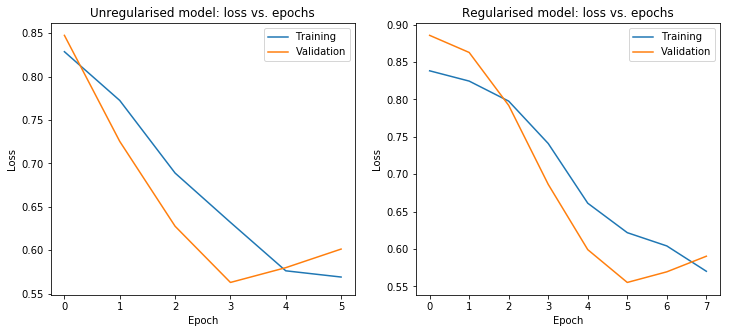

In [51]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()